In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

#### Code 4.1

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


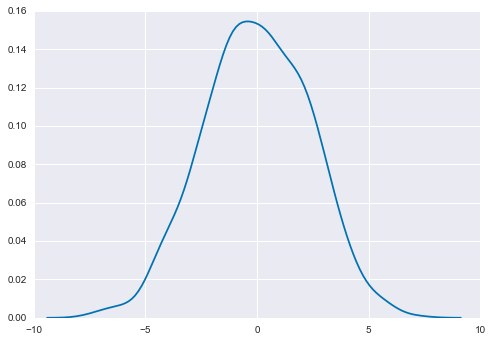

In [2]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
sns.kdeplot(pos);

#### Code 4.2 and 4.3

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


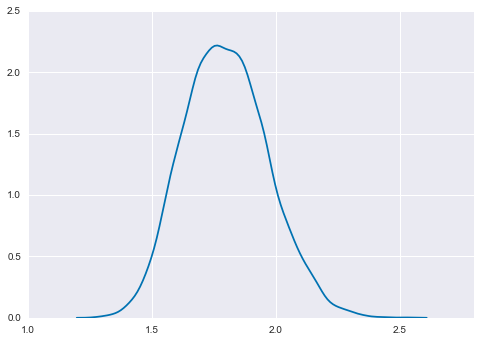

In [3]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
sns.kdeplot(pos);

#### Code 4.4

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


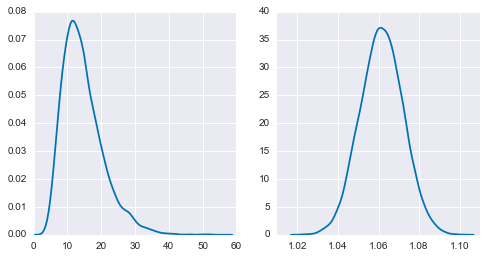

In [4]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(big, ax=ax[0])
sns.kdeplot(small, ax=ax[1]);

#### Code 4.5

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


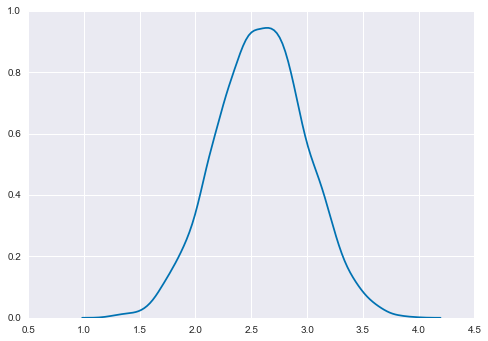

In [5]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
sns.kdeplot(log_big);

#### Code 4.6

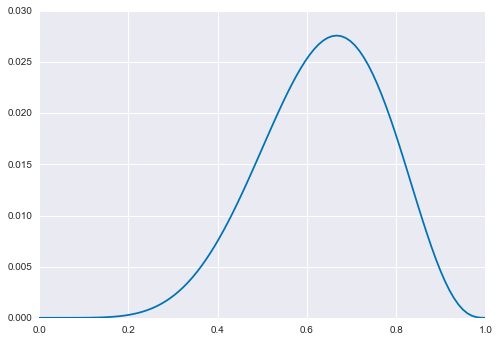

In [6]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior);

#### Code 4.7 and 4.8

In [7]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [8]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [9]:
d2 = d[d.age >= 18]

#### Code 4.11

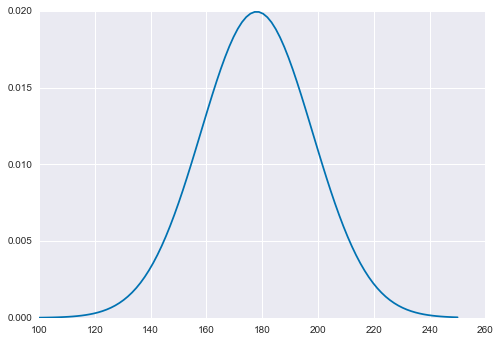

In [10]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

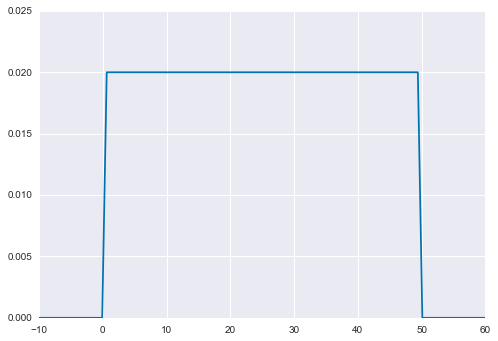

In [11]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13

/home/osvaldo/anaconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.standard_normal(self._size)
/home/osvaldo/anaconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4894: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.uniform(0.0, 1.0, self._size)
/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


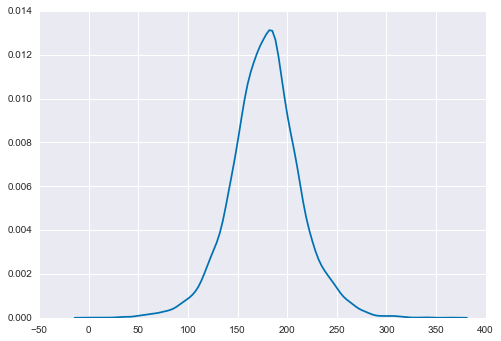

In [12]:
n_samples = 1e4
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
sns.kdeplot(prior_h);

#### Code 4.14

In [13]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = likelihood + stats.norm.logpdf(post[:,0], loc=178, scale=20) + stats.uniform.logpdf(post[:,1], loc=0, scale=50)
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.15 and 4.16

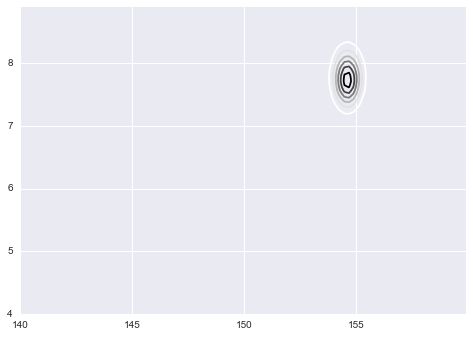

In [14]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.17 and 4.18

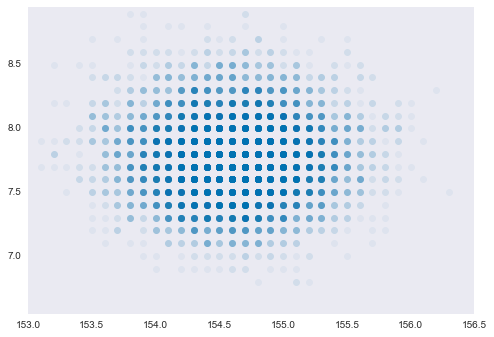

In [15]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal');
plt.grid(False)

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

#### Code 4.X

In [16]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0
NumPy 1.11.1
Pandas 0.18.1
SciPy 0.18.0
Matplotlib 1.5.2
Seaborn 0.7.1

